# 3. Basic models from scratch

## Prerequisites

  - Install Conda and create environment: see notebook *1. Conda setup*
  - Install Poetry and create configuration: see notebook *2. Poetry setup*

Make sure you select the environment (kernel) *NN* to run this notebook. Also activate it in companion terminal:  
`conda activate NN`

Let's check we have Python 3.9 running:

In [4]:
!python --version

Python 3.9.7


Let's make sure packages and dependencies are installed by Poetry:  
```poetry install```

Let's check our packages and dependencies:

In [5]:
!poetry show --tree

matplotlib 3.5.1 Python plotting package
├── cycler >=0.10
├── fonttools >=4.22.0
├── kiwisolver >=1.0.1
├── numpy >=1.17
├── packaging >=20.0
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pillow >=6.2.0
├── pyparsing >=2.2.1
├── python-dateutil >=2.7
│   └── six >=1.5 
└── setuptools-scm >=4
    ├── packaging >=20.0 
    │   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
    └── tomli >=1.0.0 
numpy 1.22.1 NumPy is the fundamental package for array computing with Python.
pytest 6.2.5 pytest: simple powerful testing with Python
├── atomicwrites >=1.0
├── attrs >=19.2.0
├── colorama *
├── iniconfig *
├── packaging *
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pluggy >=0.12,<2.0
├── py >=1.8.2
└── toml *
torch 1.10.1 Tensors and Dynamic neural networks in Python with strong GPU acceleration
└── typing-extensions *


If we want to update the Conda environment, we can run (in companion terminal):  
```
conda env update --prune -f environment_init.yml
```

If we want to update the Poetry setup, we can run (in companion terminal, making sure NN is activated):  
```
poetry update
```

We can create shortcuts for these actions in a separate **Makefile** (check its contents), which can then be called from a terminal:
```
make conda-udate
make poetry-update
```

## 1D Linear model

Note: This notebook is inspired from https://fullstackdeeplearning.com/spring2021/notebook-1/.

### Generate and visualize data

In [6]:
import numpy as np
import matplotlib.pyplot as plt

Let us create and show a dataset of 20 points:

In [7]:
n = 20
d = 1
x = np.random.uniform(-1, 1, (n, d))

Suppose that we want to approximate the 'true' function h(x) = 5x + 10:


In [8]:
weights_true = np.array([[5],])
bias_true = np.array([10])

y_true = x @ weights_true + bias_true # Matrix multiplication and element-wise addition

Let's inspect all the shapes:

In [9]:
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: (20, 1), weights: (1, 1), bias: (1,), y: (20, 1)


Let's plot our true function:

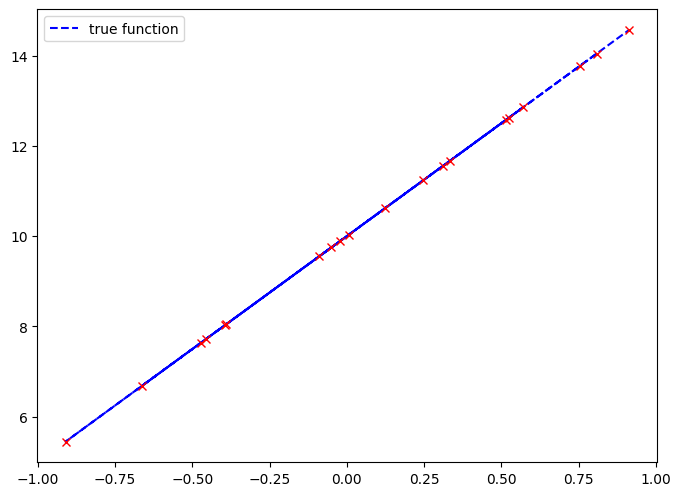

In [33]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=100)
plt.plot(x, y_true, 'b--', label='true function')
plt.plot(x, y_true, 'rx')
plt.legend()

### Linear model

In [ ]:
class LinearNN:
  def __init__(self, input_dim, num_hidden=1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    return x @ self.weights + self.bias

linear = Linear(d)
y_pred = linear(x)
plt.plot(x, y_true, marker='x', label='underlying function')
plt.scatter(x, y_pred, color='r', marker='.', label='our function')
plt.legend()

### Basic loss function: MSE


In [ ]:
# How wrong are these initial predictions, exactly?
# It's up to us, and our definition is called the loss function.
# Let's use Mean Squared Error (MSE) as our loss function.

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_true - y_pred) ** 2).mean()
  
loss = MSE()
print(f'Our initial loss is {loss(y_pred, y_true)}')

### Add back propagation

In [ ]:
# Let's use gradient descent to learn the weights and bias that minimizes the loss function.
# For this, we need the gradient of the loss function and the gradients of the linear function.

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient


class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [ ]:
# Take one step forward and one step backward to make sure nothing breaks, and that the loss decreases.
loss = MSE()
linear = Linear(d)
y_pred = linear(x)
print(loss(y_pred, y_true))
loss_gradient = loss.backward()
linear.backward(loss_gradient)
linear.update(0.1)
y_pred = linear(x)
print(loss(y_pred, y_true))

### Train using gradient descent!

In [ ]:
plt.plot(x, y_true, marker='x', label='underlying function')

loss = MSE()
linear = Linear(d)

num_epochs = 40
lr = 0.1

for epoch in range(num_epochs):
  y_pred = linear(x)
  loss_value = loss(y_pred, y_true)

  if epoch % 5 == 0:
    print(f'Epoch {epoch}, loss {loss_value}')
    plt.plot(x, y_pred.squeeze(), label=f'Epoch {epoch}')

  gradient_from_loss = loss.backward()
  linear.backward(gradient_from_loss)
  linear.update(lr)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

### 2-dimensional inputs work, too

In [ ]:
# What about 2-dimensional x?

n = 100
d = 2
x = np.random.uniform(-1, 1, (n, d))

# y = w * x + b
# y = w_0 * x_0 + w_1 * x_1 + b
# y = w@x + b

weights_true = np.array([[2, -1], ]).T
bias_true = np.array([0.5])
print(x.shape, weights_true.shape, bias_true.shape)

y_true = x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

plot_3d(x, y_true)

In [ ]:
loss = MSE()
linear = Linear(2)
y_pred = linear(x)
print(loss(y_pred, y_true))
fig = plot_3d(x, y_true, y_pred)

In [ ]:
from typing import Callable

def fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=20)
plot_3d(x, y_true, linear(x))

## Basic regression with a Multi-layer Perceptron

So, we now have a way to automatically fit a linear function to N-dimensional data.

How can this be made to work for non-linear data?

In [ ]:
# Make non-linear data

n = 200
d = 2
x = np.random.uniform(-1, 1, (n, d))

weights_true = np.array([[5, 1],]).T
bias_true = np.array([1])

y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

plot_3d(x, y_true)

In [ ]:
# We can train just fine, but the final loss will remain high, as our linear function is incapable
# of representing the data.

loss = MSE()
linear = Linear(d)
fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, linear(x))

### Add non-linearity: ReLU

In [ ]:
# In order to learn non-linear functions, we need non-linearities in our model.

class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = np.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      # import pdb; pdb.set_trace()  # By the way, this is how you can debug
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient


relu = Relu()
input_ = np.expand_dims(np.array([1, 0.5, 0, -0.5, -1]), -1)
print(relu(input_))
print(relu.backward(input_))

### Train our new non-linear model

In [ ]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 1)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)
plot_3d(x, y_true, y_pred)

In [ ]:
# Test just one forward and backward step
loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.1)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)

In [ ]:
fit(x, y_true, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x))

### Same thing, in PyTorch

In [ ]:
import torch
import torch.nn as nn


class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, num_hidden)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, 1)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2


loss = nn.MSELoss()
model = TorchModel(d, 10)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

In [ ]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward()
optimizer.step()

y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

In [ ]:
# Now we run the training loop

def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    print(loss_value)
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x_tensor).detach())

### Same thing, in Tensorflow/Keras

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

inputs = keras.Input(shape=(2,))
l1 = layers.Dense(10, activation='relu', name='dense_1')(inputs)
outputs = layers.Dense(1, name='regression')(l1)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.1))

model.fit(x, y_true, epochs=10)

y_pred = model.predict(x)

plot_3d(x, y_true, model(x))